In this notebook I will be exploring the NYC Airbnb data set in order to find a good prediction model for the outcome variable "price". After some data cleaning and exploratory data analysis I will evaluate the model performances of 3 different models (linear regression, ridge regression, lasso regression) with different input variables (phase 1-4) and check the model assumptions of linear regression. 


- Phase 1: With outliers, no polynomial terms
- Phase 2: With outliers, with polynomial terms
- Phase 3: No outliers, no polynomial terms
- Phase 4: No outliers, no polynomial terms


**The specific steps are the following:**

**1. Data Cleaning**


**2. Exploratory Data Analysis**
    * Categorical variables
    * Numerical variables
    * Outcome variable
    
    
**3. Model Building (Phase 1-4)**
    * Data splitting
    * Preprocessing
    * Model building
    
    
**4. Model Comparison (Phase 1-4)**
    * Predictions
    * Model comparison
    
    
**5. Check Model Assumptions for Linear Regression**
    * Linearity
    * Normality
    * Homoscedasticity
    * Multicollinearity

In [97]:
!pip install --upgrade seaborn

'0.11.0'

In [58]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
# plot theme
plt.style.use('ggplot')

# 1. Data Cleaning 

In [3]:
df = pd.read_csv('AB_NYC_2019.csv')

In [4]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


The variable "id" will be dropped as it doesn't provide useful information to our prediction models. Considering the host in the prediction will cause our models to be too large and time consuming, thus, I will drop the variables "host_id" and "host_name". However, in the real world these variables could have an influence on the price. Lastly, I will drop the "name" and "last_reviews" variable.

In [5]:
#drop column
df.drop(columns = ['id', 'host_id', 'host_name', 'last_review', 'name'], axis = 1, inplace = True)

In [6]:
#quick info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


There are many na values for the variable "reviews_per_months". For these listings, there are no reviews to begin with, so I will fill the missing values with 0.

In [7]:
#check for NA values
df.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [8]:
df['reviews_per_month'].fillna('0', inplace=True)

In [9]:
#check for NA values
df.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

# 2. Exploratory Data Analysis

## Categorical variables

### neighbourhood_group

Most of the listing are in Manhatten or in Brooklyn, probably due to the amount of tourists visiting and wanting to stay in these areas. Queens, Bronx and Staten Island have significantly fewer listings as these are more residential neighbourhoods.

In [10]:
df["neighbourhood_group"].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

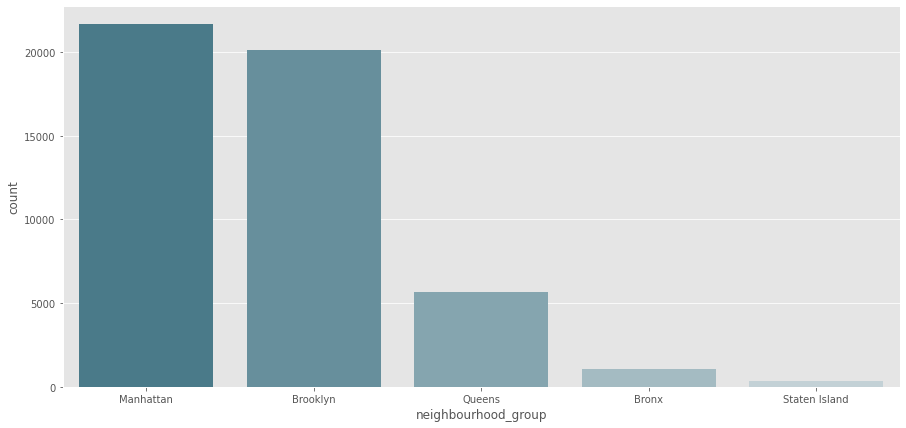

In [11]:
plt.figure(figsize=(15,7))
sns.countplot(x="neighbourhood_group", data=df,
            order=df["neighbourhood_group"].value_counts().index,
            palette = sns.diverging_palette(220, 20, n=12))
plt.show()

### neighbourhood

Exploring the variable "neighbourhood" can give us some insight on how residential vs. how touristic the neighbourhoods are as Airbnb is mostly used by tourists.

In [12]:
df["neighbourhood"].value_counts().head(10)

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
Name: neighbourhood, dtype: int64

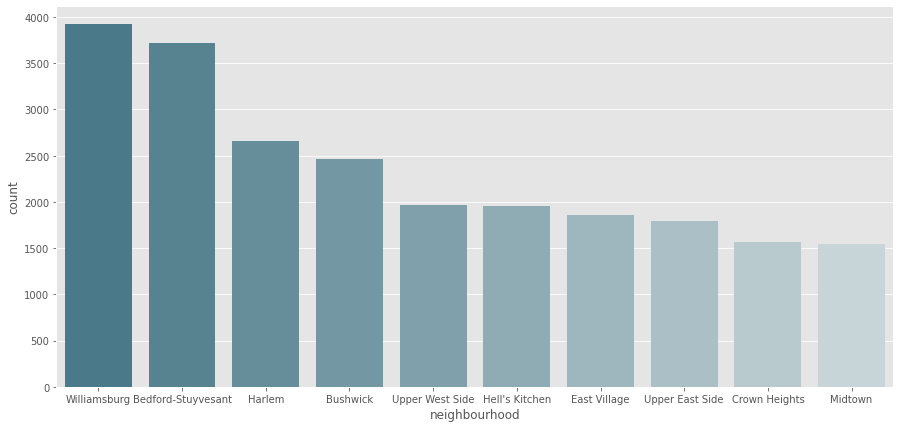

In [13]:
plt.figure(figsize=(15,7))
sns.countplot(x="neighbourhood", data=df,
            order=df["neighbourhood"].value_counts().head(10).index,
            palette = sns.diverging_palette(220, 20, n=25))
plt.show()

### room_type

The room type "shared room" is highly underrepresented, most Airbnb hosts offer either a private room or an entire apartment for rent.

In [14]:
df["room_type"].value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

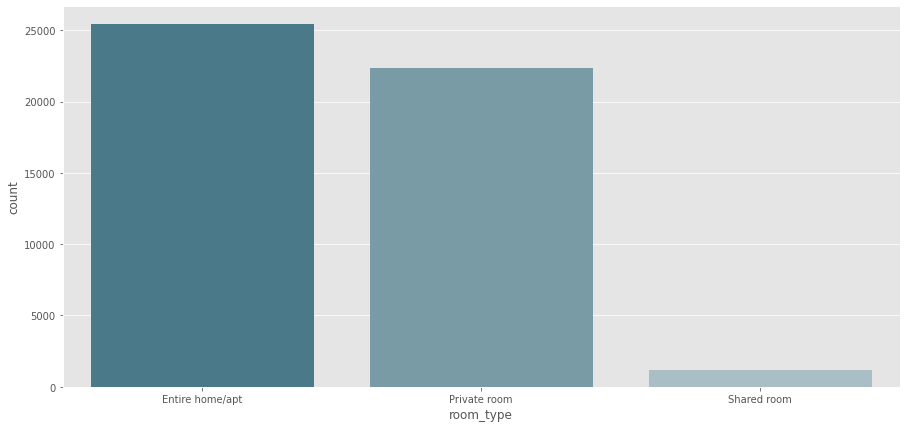

In [15]:
plt.figure(figsize=(15,7))
sns.countplot(x="room_type", data=df,
            order=df["room_type"].value_counts().index,
            palette = sns.diverging_palette(220, 20, n=8))
            
plt.show()

## Numerical variables

The distributions of the numerical variables are highly skewed due to extreme outliers. This can lead to lower prediction performances. However, it is dangerous to blindly remove these outliers as they could provide valueable information. In a later section I will run regression models with and without the outliers to see the impact on the prediction score (phase 3 and 4).

### Distributions & Outliers

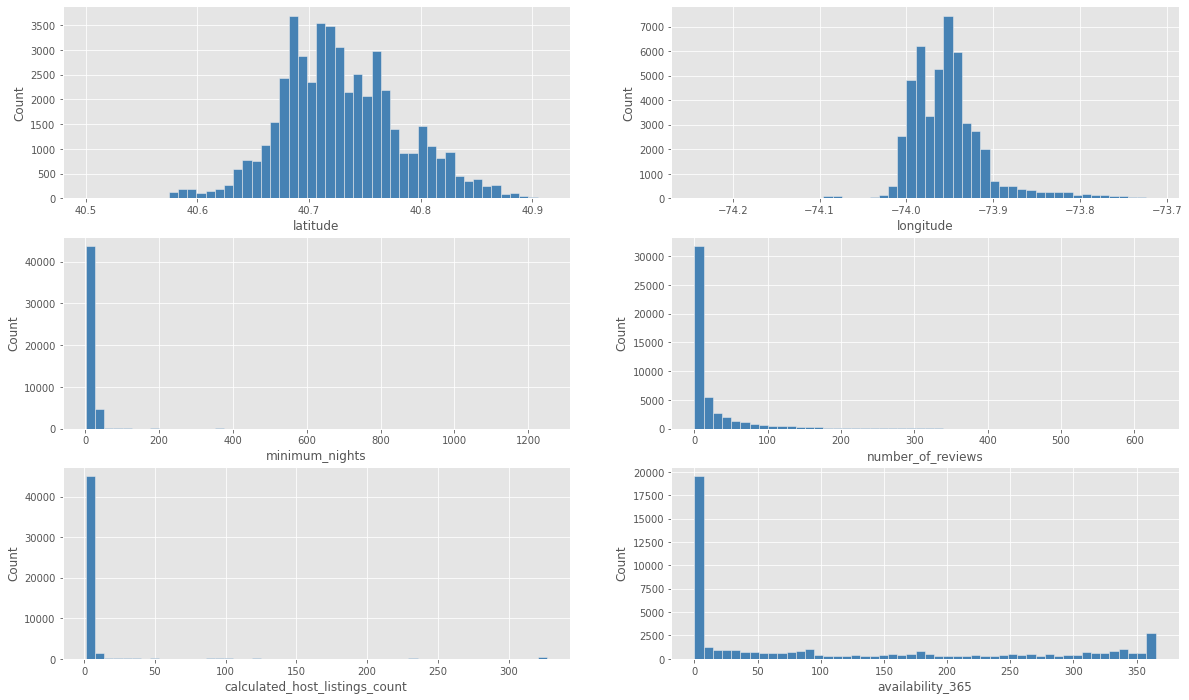

In [16]:
numeric = df.select_dtypes('number').drop(columns=["price"])
f, axes = plt.subplots(3, 2, figsize=(20, 12))
#mylist = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [3,0]] axes locations
mylist1 = [0, 0, 1, 1, 2, 2]
mylist2 = [0, 1, 0, 1, 0, 1]
for i, j in enumerate(numeric.columns): #i: axes locations, j: column names
    sns.histplot(x=df[j], ax=axes[mylist1[i], mylist2[i]], bins=50, color="steelblue", alpha=1)

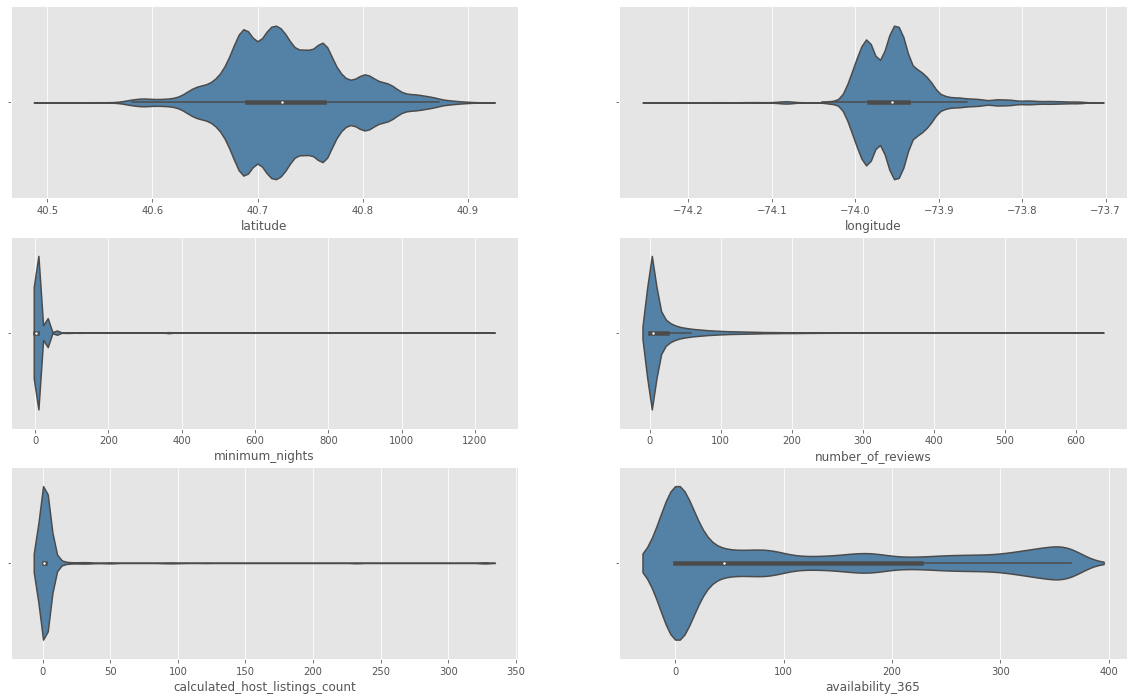

In [17]:
f, axes = plt.subplots(3, 2, figsize=(20, 12))
#mylist = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [3,0]] axes locations
mylist1 = [0, 0, 1, 1, 2, 2]
mylist2 = [0, 1, 0, 1, 0, 1]
for i, j in enumerate(numeric.columns): #i: axes locations, j: column names
    sns.violinplot(x=df[j], ax=axes[mylist1[i], mylist2[i]], color="steelblue")

## Target variable

The outcome variable "price" is highly skewed with the price reaching as high as 10000. I will perform a log+1 transformation for a more normal distribution and for interpretability.

c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


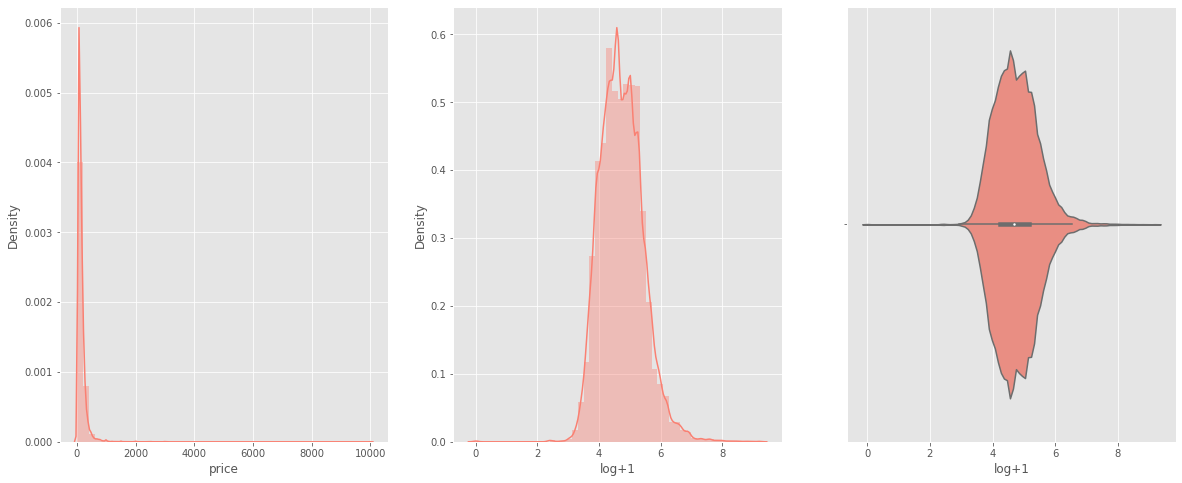

In [18]:
f, axes = plt.subplots(1,3, figsize=(20,8))
sns.distplot(df['price'], color="salmon", ax=axes[0])
sns.distplot(np.log(df['price']+1),color="salmon", ax=axes[1])
sns.violinplot(x=np.log(df["price"]+1), color="salmon", ax=axes[2])
axes[1].set_xlabel('log+1')
axes[2].set_xlabel('log+1')
plt.show()

In [19]:
#log+1 transform "price"
df["price"] = np.log(df["price"]+1)

# 3. Model Building

## 3.1. Data Splitting

In [20]:
########################################## DATA SPLITTING  ################################################
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

## 3.2. Preprocessing

I will apply one hot encoding to all categorical variables and scale all numerical variables. I will also prepare a polynomial transformation for the numerical variables for phase 2 and 4.

In [21]:
########################################## PREPROCESSING  ################################################
#categorical variables
categorical_variables = ["neighbourhood_group", "neighbourhood", "room_type"]
categorical_transformer = Pipeline(
        [
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]
)

#numeric variables
numeric_transformer = Pipeline(
        [
            ("scaler", StandardScaler())
        ]
)

#combine into ColumnTransformer
preprocessor = ColumnTransformer(
    [
        ("categoricals", categorical_transformer, categorical_variables),
        ("numericals", numeric_transformer, numeric.columns)
    ],
    remainder="passthrough"
)

########################################## PREPROCESSING POLY  ################################################
Poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
polynomial_transformer = Pipeline(
        [
            ("poly", Poly)
        ]
)

preprocessor_poly = ColumnTransformer(
    [
        ("categoricals", categorical_transformer, categorical_variables),
        ("polynomials", polynomial_transformer, numeric.columns),
        ("numericals", numeric_transformer, numeric.columns),
    ],
    remainder="passthrough"
)

## 3.3. Model Building

In this step I am creating a function that will perform a grid search and cross validation in order to find the best parameters for linear, ridge and lasso regression in the respective phases 1-4. The function will be applied to the training sets. The best parameters will then be used for the test set in a later section.

### Define Models & Parameters

In [22]:
linreg = LinearRegression()
ridge = Ridge()
lasso = Lasso()

params_linreg = {'model__fit_intercept':[True,False], 
                  'model__normalize':[True,False], 
                  'model__copy_X':[True, False]}
params_ridge = {'model__alpha':[0.001,0.01,0.1,1,10,100,1000]}
params_lasso = {'model__alpha':[0.0001,0.001,0.01,0.1,1]}

### Function for Model Building

In [23]:
def cv_model(X_train, y_train, model, params, cv=5):
    ##########################################  BUILDING MDOEL  #################################################
    pipe = Pipeline(
        [
            ("preprocessing", preprocessor),
            ("model", model)
        ]
    )
    ##########################################  GRIDSEARCH & CV  #################################################
    #gridsearch parameters
    params = params


    #gridsearch 
    cv = GridSearchCV(
      pipe, 
      params, 
      cv = cv, 
      scoring = "neg_mean_squared_error", 
      )

    #results
    cv.fit(X_train, y_train)
    print(f'Best score: {cv.best_score_:.3f}\n')
    print(f'Best parameter set: {cv.best_params_}\n')
    print(f'RMSE: {sqrt(abs(cv.best_score_)):.3f}')

### Model Building (Phase 1: with outliers, no polynomial terms)

In [24]:
print("####################  Linear Regression  ####################")
cv_model(X_train, y_train, linreg, params_linreg)

print("\n\n")

print("####################  Ridge Regression  ####################")
cv_model(X_train, y_train, ridge, params_ridge)
print("\n\n")

print("####################  Lasso Regression  ####################")
cv_model(X_train, y_train, lasso, params_lasso)

####################  Linear Regression  ####################
Best score: -0.229

Best parameter set: {'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': False}

RMSE: 0.478



####################  Ridge Regression  ####################
Best score: -0.228

Best parameter set: {'model__alpha': 10}

RMSE: 0.478



####################  Lasso Regression  ####################


c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.802197723715835, tolerance: 1.334790614683029
  model = cd_fast.sparse_enet_coordinate_descent(


Best score: -0.229

Best parameter set: {'model__alpha': 0.0001}

RMSE: 0.478


### Model Building (Phase 2: with outliers, with polynomial terms)

In [26]:
def cv_model_poly(X_train, y_train, model, params, cv=5):
    ##########################################  BUILDING MDOEL  #################################################
    pipe = Pipeline(
        [
            ("preprocessing", preprocessor_poly),
            ("model", model)
        ]
    )
    ##########################################  GRIDSEARCH & CV  #################################################
    #gridsearch parameters
    params = params


    #gridsearch 
    cv = GridSearchCV(
      pipe, 
      params, 
      cv = cv, 
      scoring = "neg_mean_squared_error", 
      )

    #results
    cv.fit(X_train, y_train)
    print(f'Best score: {cv.best_score_:.3f}\n')
    print(f'Best parameter set: {cv.best_params_}\n')
    print(f'RMSE: {sqrt(abs(cv.best_score_)):.3f}')

In [27]:
print("####################  Linear Regression  ####################")
cv_model_poly(X_train, y_train, linreg, params_linreg)
print("\n\n")

print("####################  Ridge Regression  ####################")
cv_model_poly(X_train, y_train, ridge, params_ridge)
print("\n\n")

print("####################  Lasso Regression  ####################")
cv_model_poly(X_train, y_train, lasso, params_lasso)

####################  Linear Regression  ####################
Best score: -0.228

Best parameter set: {'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': True}

RMSE: 0.477



####################  Ridge Regression  ####################
Best score: -0.474

Best parameter set: {'model__alpha': 100}

RMSE: 0.688



####################  Lasso Regression  ####################


c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3104.8959720105504, tolerance: 1.334790614683029
  model = cd_fast.sparse_enet_coordinate_descent(
c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3091.5064799334755, tolerance: 1.3300138882200692
  model = cd_fast.sparse_enet_coordinate_descent(
c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3104.5504583001134, tolerance: 1.3308302505194403
  model = cd_fast.sparse_enet_coordinate_descent(
c:

Best score: -0.228

Best parameter set: {'model__alpha': 0.0001}

RMSE: 0.478


c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3889.571212915428, tolerance: 1.6686101786001077
  model = cd_fast.sparse_enet_coordinate_descent(


### Model Building (Phase 3: without outliers, no polynomial terms)

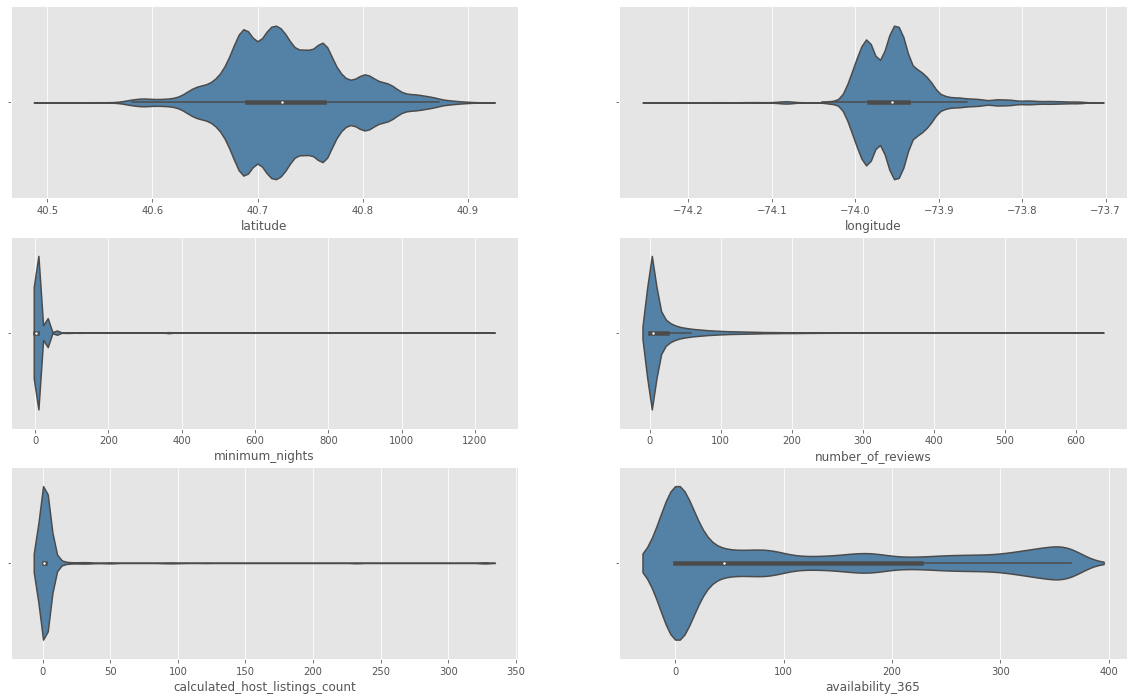

In [28]:
f, axes = plt.subplots(3, 2, figsize=(20, 12))
#mylist = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [3,0]] axes locations
mylist1 = [0, 0, 1, 1, 2, 2]
mylist2 = [0, 1, 0, 1, 0, 1]
for i, j in enumerate(numeric.columns): #i: axes locations, j: column names
    sns.violinplot(x=df[j], ax=axes[mylist1[i], mylist2[i]], color="steelblue")

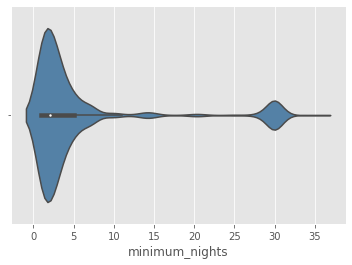

(521, 11)

In [29]:
sns.violinplot(x=df[~(df["minimum_nights"]>35)]["minimum_nights"], color="steelblue")
plt.show()
df[df["minimum_nights"]>35].shape

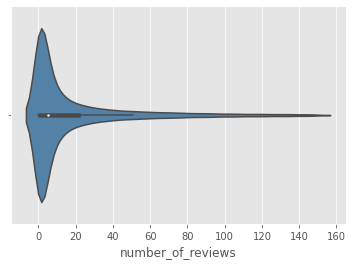

(1345, 11)

In [85]:
sns.violinplot(x=df[~(df["number_of_reviews"]>150)]["number_of_reviews"], color="steelblue")
plt.show()
df[df["number_of_reviews"]>150].shape

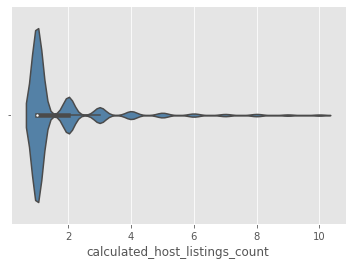

(2967, 11)

In [86]:
sns.violinplot(x=df[~(df["calculated_host_listings_count"]>10)]["calculated_host_listings_count"], color="steelblue")
plt.show()
df[df["calculated_host_listings_count"]>10].shape

In [32]:
df1 = df[~(df["price"]<3) | (df["price"]>8)]

In [33]:
df1.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,3,0,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,10,9,0.1,1,0


In [34]:
#remove extreme outliers in target variable
df1 = df[~(df["price"]<3) | (df["price"]>8)]
#remove extreme outliers in minimum_nights
df1 = df1[~(df["minimum_nights"]>35)]
#remove extreme outliers in number_of_reviews
df1 = df1[~(df["number_of_reviews"]>150)]
#remove extreme outliers in calculated_host_listings_count
df1 = df1[~(df["calculated_host_listings_count"]>10)]

<ipython-input-34-734cd0a830e3>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[~(df["minimum_nights"]>35)]
<ipython-input-34-734cd0a830e3>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[~(df["number_of_reviews"]>150)]
<ipython-input-34-734cd0a830e3>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[~(df["calculated_host_listings_count"]>10)]


In [36]:
########################################## DATA SPLITTING  ################################################
X_outliers = df1.drop(columns=['price'])
y_outliers = df1['price']
X_outliers_train, X_outliers_test, y_outliers_train, y_outliers_test = train_test_split(X_outliers, y_outliers, test_size=0.3, random_state=10)

In [37]:
print("####################  Linear Regression  ####################")
cv_model(X_outliers_train, y_outliers_train, linreg, params_linreg)
print("\n\n")

print("####################  Ridge Regression  ####################")
cv_model(X_outliers_train, y_outliers_train, ridge, params_ridge)
print("\n\n")

print("####################  Lasso Regression  ####################")
cv_model(X_outliers_train, y_outliers_train, lasso, params_lasso)

####################  Linear Regression  ####################
Best score: -0.206

Best parameter set: {'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': False}

RMSE: 0.454



####################  Ridge Regression  ####################
Best score: -0.206

Best parameter set: {'model__alpha': 1}

RMSE: 0.453



####################  Lasso Regression  ####################
Best score: -0.206

Best parameter set: {'model__alpha': 0.0001}

RMSE: 0.454


### Model Building (Phase 4: without outliers, with polynomial terms)

In [38]:
print("####################  Linear Regression  ####################")
cv_model_poly(X_outliers_train, y_outliers_train, linreg, params_linreg)
print("\n\n")

print("####################  Ridge Regression  ####################")
cv_model_poly(X_outliers_train, y_outliers_train, ridge, params_ridge)
print("\n\n")

print("####################  Lasso Regression  ####################")
cv_model_poly(X_outliers_train, y_outliers_train, lasso, params_lasso)

####################  Linear Regression  ####################
Best score: -0.204

Best parameter set: {'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': True}

RMSE: 0.451



####################  Ridge Regression  ####################
Best score: -0.284

Best parameter set: {'model__alpha': 1}

RMSE: 0.533



####################  Lasso Regression  ####################


c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2514.411001480898, tolerance: 1.1243693054369146
  model = cd_fast.sparse_enet_coordinate_descent(
c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2517.1029668264623, tolerance: 1.1314996875161334
  model = cd_fast.sparse_enet_coordinate_descent(
c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2518.5125131622913, tolerance: 1.1210128234239838
  model = cd_fast.sparse_enet_coordinate_descent(
c:

Best score: -0.204

Best parameter set: {'model__alpha': 0.0001}

RMSE: 0.452


c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3160.3536803426773, tolerance: 1.408820198369998
  model = cd_fast.sparse_enet_coordinate_descent(


# 4. Model Comparison

In this section I am going to compare the scores of our regression models in the phases 1-4. I will use the test sets for prediction and evaluation.

## 4.1. Model Predictions

### Phase 1

In [39]:
#Linear Regression
lr_pred = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
pipe_lr = Pipeline(
        [
            ("preprocessing", preprocessor),
            ("lr", lr_pred)
        ]
)

pipe_lr.fit(X_train, y_train)
prediction_lr = pipe_lr.predict(X_test)

#Ridge
ridge_pred = Ridge(alpha=10)
pipe_ridge = Pipeline(
        [
            ("preprocessing", preprocessor),
            ("ridge", ridge_pred)
        ]
)

pipe_ridge.fit(X_train, y_train)
prediction_ridge = pipe_ridge.predict(X_test)

#Lasso
lasso_pred = Lasso(alpha=0.0001)
pipe_lasso = Pipeline(
        [
            ("preprocessing", preprocessor),
            ("lasso", lasso_pred)
        ]
)

pipe_lasso.fit(X_train, y_train)
prediction_lasso = pipe_lasso.predict(X_test)

### Phase 2

In [40]:
#Linear Regression
lr_pred_poly = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
pipe_lr_poly = Pipeline(
        [
            ("preprocessing", preprocessor_poly),
            ("lr", lr_pred_poly)
        ]
)

pipe_lr_poly.fit(X_train, y_train)
prediction_lr_poly = pipe_lr_poly.predict(X_test)

#Ridge
ridge_pred_poly = Ridge(alpha=100)
pipe_ridge_poly = Pipeline(
        [
            ("preprocessing", preprocessor_poly),
            ("ridge", ridge_pred_poly)
        ]
)

pipe_ridge_poly.fit(X_train, y_train)
prediction_ridge_poly = pipe_ridge_poly.predict(X_test)

#Lasso
lasso_pred_poly = Lasso(alpha=0.0001)
pipe_lasso_poly = Pipeline(
        [
            ("preprocessing", preprocessor_poly),
            ("lasso", lasso_pred_poly)
        ]
)

pipe_lasso_poly.fit(X_train, y_train)
prediction_lasso_poly = pipe_lasso_poly.predict(X_test)

c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3889.571212915428, tolerance: 1.6686101786001077
  model = cd_fast.sparse_enet_coordinate_descent(


### Phase 3

In [41]:
#Linear Regression
lr_pred = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
pipe_lr = Pipeline(
        [
            ("preprocessing", preprocessor),
            ("lr", lr_pred)
        ]
)

pipe_lr.fit(X_outliers_train, y_outliers_train)
prediction_lr_outliers = pipe_lr.predict(X_outliers_test)

#Ridge
ridge_pred = Ridge(alpha=1)
pipe_ridge = Pipeline(
        [
            ("preprocessing", preprocessor),
            ("ridge", ridge_pred)
        ]
)

pipe_ridge.fit(X_outliers_train, y_outliers_train)
prediction_ridge_outliers = pipe_ridge.predict(X_outliers_test)

#Lasso
lasso_pred = Lasso(alpha=0.0001)
pipe_lasso = Pipeline(
        [
            ("preprocessing", preprocessor),
            ("lasso", lasso_pred)
        ]
)

pipe_lasso.fit(X_outliers_train, y_outliers_train)
prediction_lasso_outliers = pipe_lasso.predict(X_outliers_test)

### Phase 4

In [42]:
#Linear Regression
lr_pred_poly = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
pipe_lr_poly = Pipeline(
        [
            ("preprocessing", preprocessor_poly),
            ("lr", lr_pred_poly)
        ]
)

pipe_lr_poly.fit(X_outliers_train, y_outliers_train)
prediction_lr_poly_outliers = pipe_lr_poly.predict(X_outliers_test)

#Ridge
ridge_pred_poly = Ridge(alpha=1)
pipe_ridge_poly = Pipeline(
        [
            ("preprocessing", preprocessor_poly),
            ("ridge", ridge_pred_poly)
        ]
)

pipe_ridge_poly.fit(X_outliers_train, y_outliers_train)
prediction_ridge_poly_outliers = pipe_ridge_poly.predict(X_outliers_test)

#Lasso
lasso_pred_poly = Lasso(alpha=0.0001)
pipe_lasso_poly = Pipeline(
        [
            ("preprocessing", preprocessor_poly),
            ("lasso", lasso_pred_poly)
        ]
)

pipe_lasso_poly.fit(X_outliers_train, y_outliers_train)
prediction_lasso_poly_outliers = pipe_lasso_poly.predict(X_outliers_test)

c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3160.3536803426773, tolerance: 1.408820198369998
  model = cd_fast.sparse_enet_coordinate_descent(


## 4.2. Model Comparison

* **MAE:** Takes mean of the absolute difference the predicted and actual values.
* **RMSE:** Takes the square root of the mean of squared errors.
* **R2:** Represents the proportion of the variance in the dependent variable that is predictable from the independent variables. 


As we can see from the results, all of our models have similar scores and have significant prediction errors.
We get the best score with linear regression in phase 4. This is no surprise as we removed extreme outliers and performed polynomial transformation in this phase. However, as mentioned earlier, it is dangerous to remove outliers that are not typos. Furthermore, it is no surprise that Ridge and Lasso didn't improve the scores as these models are mainly used to tackle multicollinearity and overfitting. In this case, by comparing the training and test scores, we don't seem to have a problem with overfitting. Instead, more investigation into the extreme outliers and more feature engineering are needed to improve our models performances. Another approach is to consider different models that are more robust to outliers.

In [56]:
print("###############################################  PHASE 1  ###################################################\n")
print("####################  Linear Regression  ####################")
print('MAE: %0.3f'% mean_absolute_error(y_test, prediction_lr))
print('RMSE: %0.3f'% np.sqrt(mean_squared_error(y_test, prediction_lr)))   
print('R2 %0.3f'% r2_score(y_test, prediction_lr))

print("####################  Ridge Regression  ####################")
print('MAE: %0.3f'% mean_absolute_error(y_test, prediction_ridge))
print('RMSE: %0.3f'% np.sqrt(mean_squared_error(y_test, prediction_ridge)))   
print('R2 %0.3f'% r2_score(y_test, prediction_ridge))

print("####################  Lasso Regression  ####################")
print('MAE: %0.3f'% mean_absolute_error(y_test, prediction_lasso))
print('RMSE: %0.3f'% np.sqrt(mean_squared_error(y_test, prediction_lasso)))   
print('R2 %0.3f'% r2_score(y_test, prediction_lasso))


print("###############################################  PHASE 2  ###################################################\n")
print("####################  Linear Regression  ####################")
print('MAE: %0.3f'% mean_absolute_error(y_test, prediction_lr_poly))
print('RMSE: %0.3f'% np.sqrt(mean_squared_error(y_test, prediction_lr_poly)))   
print('R2 %0.3f'% r2_score(y_test, prediction_lr_poly))

print("####################  Ridge Regression  ####################")
print('MAE: %0.3f'% mean_absolute_error(y_test, prediction_ridge_poly))
print('RMSE: %0.3f'% np.sqrt(mean_squared_error(y_test, prediction_ridge_poly)))   
print('R2 %0.3f'% r2_score(y_test, prediction_ridge_poly))

print("####################  Lasso Regression  ####################")
print('MAE: %0.3f'% mean_absolute_error(y_test, prediction_lasso_poly))
print('RMSE: %0.3f'% np.sqrt(mean_squared_error(y_test, prediction_lasso_poly)))   
print('R2 %0.3f'% r2_score(y_test, prediction_lasso_poly))


print("###############################################  PHASE 3  ###################################################\n")
print("####################  Linear Regression  ####################")
print('MAE: %0.3f'% mean_absolute_error(y_outliers_test, prediction_lr_outliers))
print('RMSE: %0.3f'% np.sqrt(mean_squared_error(y_outliers_test, prediction_lr_outliers)))   
print('R2 %0.3f'% r2_score(y_outliers_test, prediction_lr_outliers))

print("####################  Ridge Regression  ####################")
print('MAE: %0.3f'% mean_absolute_error(y_outliers_test, prediction_ridge_outliers))
print('RMSE: %0.3f'% np.sqrt(mean_squared_error(y_outliers_test, prediction_ridge_outliers)))   
print('R2 %0.3f'% r2_score(y_outliers_test, prediction_ridge_outliers))

print("####################  Lasso Regression  ####################")
print('MAE: %0.3f'% mean_absolute_error(y_outliers_test, prediction_lasso_outliers))
print('RMSE: %0.3f'% np.sqrt(mean_squared_error(y_outliers_test, prediction_lasso_outliers)))   
print('R2 %0.3f'% r2_score(y_outliers_test, prediction_lasso_outliers))


print("###############################################  PHASE 4  ###################################################\n")
print("####################  Linear Regression  ####################")
print('MAE: %0.3f'% mean_absolute_error(y_outliers_test, prediction_lr_poly_outliers))
print('RMSE: %0.3f'% np.sqrt(mean_squared_error(y_outliers_test, prediction_lr_poly_outliers)))   
print('R2 %0.3f'% r2_score(y_outliers_test, prediction_lr_poly_outliers))

print("####################  Ridge Regression  ####################")
print('MAE: %0.3f'% mean_absolute_error(y_outliers_test, prediction_ridge_poly_outliers))
print('RMSE: %0.3f'% np.sqrt(mean_squared_error(y_outliers_test, prediction_ridge_poly_outliers)))   
print('R2 %0.3f'% r2_score(y_outliers_test, prediction_ridge_poly_outliers))

print("####################  Lasso Regression  ####################")
print('MAE: %0.3f'% mean_absolute_error(y_outliers_test, prediction_lasso_poly_outliers))
print('RMSE: %0.3f'% np.sqrt(mean_squared_error(y_outliers_test, prediction_lasso_poly_outliers)))   
print('R2 %0.3f'% r2_score(y_outliers_test, prediction_lasso_poly_outliers))

###############################################  PHASE 1  ###################################################

####################  Linear Regression  ####################
MAE: 0.337
RMSE: 0.467
R2 0.539
####################  Ridge Regression  ####################
MAE: 0.336
RMSE: 0.467
R2 0.539
####################  Lasso Regression  ####################
MAE: 0.337
RMSE: 0.468
R2 0.538
###############################################  PHASE 2  ###################################################

####################  Linear Regression  ####################
MAE: 0.334
RMSE: 0.466
R2 0.541
####################  Ridge Regression  ####################
MAE: 0.535
RMSE: 0.679
R2 0.029
####################  Lasso Regression  ####################
MAE: 0.336
RMSE: 0.468
R2 0.539
###############################################  PHASE 3  ###################################################

####################  Linear Regression  ####################
MAE: 0.331
RMSE: 0.456
R2 0.555
#############

# 5. Check Model Assumptions for Linear Regression

Most of the independent variables don't have a linear relationship with the outcome variable. In addition to that there are many extreme outliers in the data. Furthermore, the residuals from the linear regression are not normally distributed enough and show signs of heteroscedasticity. These violations have a great impact on the prediction of the model. Lastly, ridge and lasso regression will not show significant improvements as there is no big problem with multicollinearity. More feature engineering or different models are needed.

## Linear Regression Model

In [83]:
#split data
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#ohe and scale
column_transform = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), ["neighbourhood_group", "neighbourhood", "room_type"]),
    (StandardScaler(),numeric.columns),
    remainder = "passthrough")

#define model
linreg = LinearRegression()

#pipeline / model
pipe_linreg = make_pipeline(column_transform, linreg)

#5 fold cross validation of linreg model
#cross_val_score(pipe_linreg, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean()

#RMSR score
# print("RMSE: {:.2f}".format(sqrt(abs(cross_val_score(pipe_linreg, X_train, y_train, cv=5, 
#                                                  scoring="neg_mean_squared_error").mean()))))

## 5.1. Linearity

### Scatter plots (independent variables vs dependent variable)

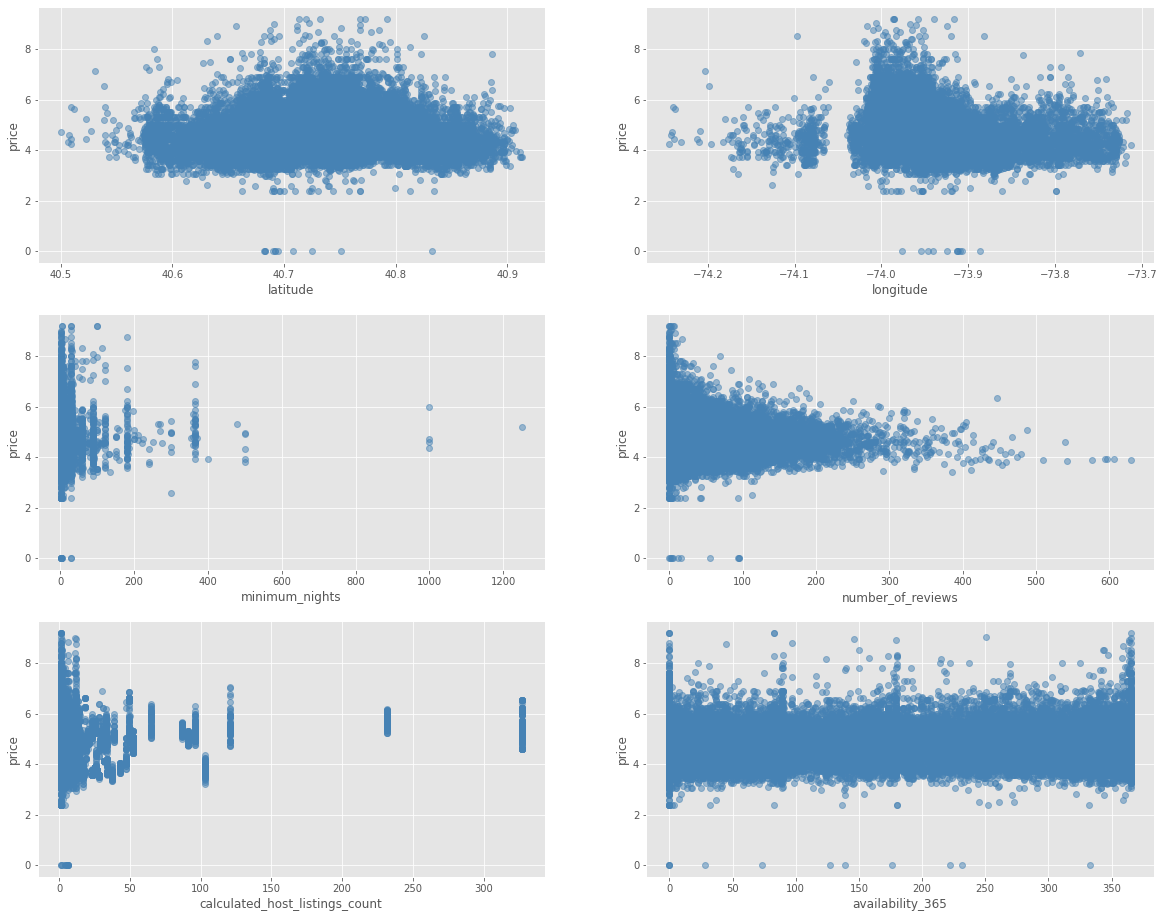

In [94]:
f, axes = plt.subplots(3, 2, figsize=(20, 16))
#mylist = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1]] axes locations
mylist1 = [0, 0, 1, 1, 2, 2]
mylist2 = [0, 1, 0, 1, 0, 1]
for i, j in enumerate(numeric.columns): #numeric columns without "Rating"
    sns.regplot(x=df[j], y=df["price"], #i: axes locations, j: column names
            ax=axes[mylist1[i],mylist2[i]],
            #lowess=True, #line of best fit
            fit_reg=False,
            scatter_kws={"alpha":0.5, "color":"steelblue"}, #scatter points alpha
            line_kws={"color":"black", "lw":2}) #line width & color

### Actual vs predicted

In [87]:
def actual_predicted(X_train,y_train,model,X_test,y_test):
    
    #model predictions
    model.fit(X_train,y_train)           #trained on
    predictions = model.predict(X_test)  #applied to
    
    #plot
    ax = sns.regplot(x=y_test, y=predictions, 
            scatter_kws={"alpha":0.65, "color":"steelblue"},
            lowess=True,
            line_kws={"color":"black", "lw":2})
    ax.set(xlabel='Actual', ylabel='Predicted values')
    plt.show()

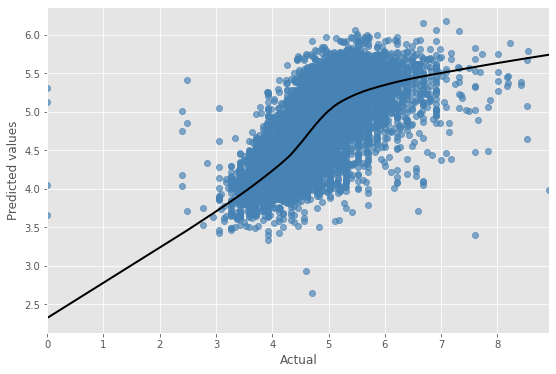

In [88]:
plt.figure(figsize=(9,6))
actual_predicted(X_train,y_train,pipe_linreg,X_test,y_test)

## 5.2. Normality

### Residual dist plot

In [72]:
def residual_dist_plot(X_train,y_train,model,X_test,y_test):
    
    #model predictions
    model.fit(X_train,y_train)           #trained on
    predictions = model.predict(X_test)  #applied to
    
    #residuals
    residuals = y_test - predictions

    #plot
    plt.figure(figsize=(10,10))
    sns.distplot(residuals, fit=norm, color="steelblue")
    plt.title("Residuals Distribution Plot",size=15, weight='bold')

    plt.show()

c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


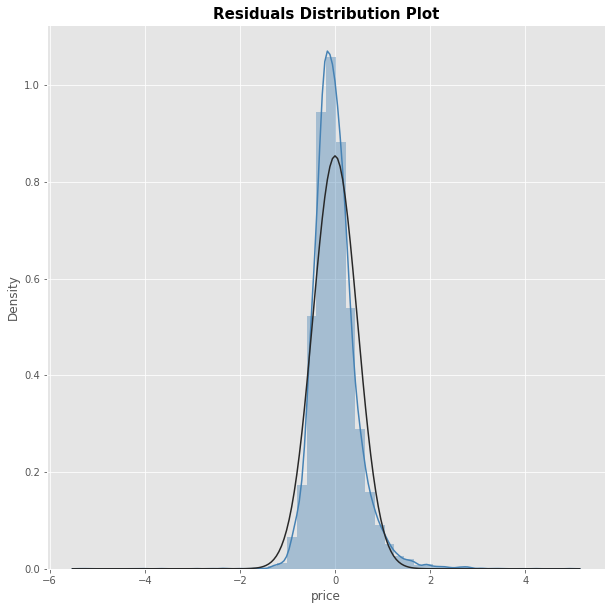

In [73]:
residual_dist_plot(X_train,y_train,pipe_linreg,X_test,y_test)

In [74]:
def residual_qq_plot(X_train,y_train,model,X_test,y_test):
    
    #model predictions
    model.fit(X_train,y_train)           #trained on
    predictions = model.predict(X_test)  #applied to
    
    #residuals
    residuals = y_test - predictions

    #plot
    plt.figure(figsize=(7,7))
    stats.probplot(residuals, plot=plt)

    plt.show()

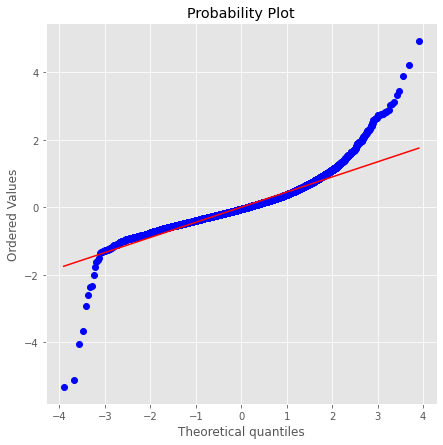

In [75]:
residual_qq_plot(X_train,y_train,pipe_linreg,X_test,y_test)

## 5.3. Homoscedasticity

### Residual plot

In [ ]:
def residual_plot(X_train,y_train,model,X_test,y_test):
    
    #model predictions
    model.fit(X_train,y_train)           #trained on
    predictions = model.predict(X_test)  #applied to
    
    #residuals
    residuals = y_test - predictions
    
    #residual plot
    ax = sns.regplot(x=predictions, y=residuals,
                    scatter_kws={"alpha":0.5, "color":"steelblue"},
                    lowess=True,
                    line_kws={"color":"black", "lw":2})
    ax.set(xlabel="Predicted values", ylabel="Residuals")
    plt.show()

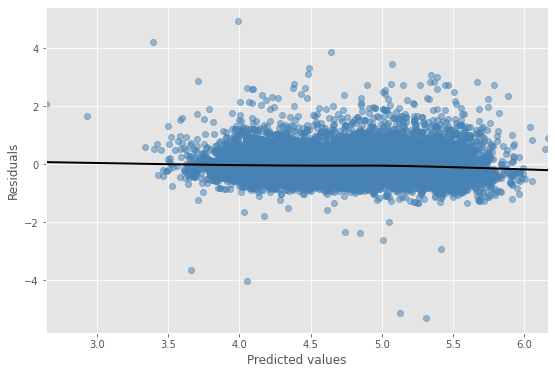

In [93]:
plt.figure(figsize=(9,6))
residual_plot(X_train, y_train, pipe_linreg, X_test, y_test)

## 5.4. Multicollinearity

### Eigen values

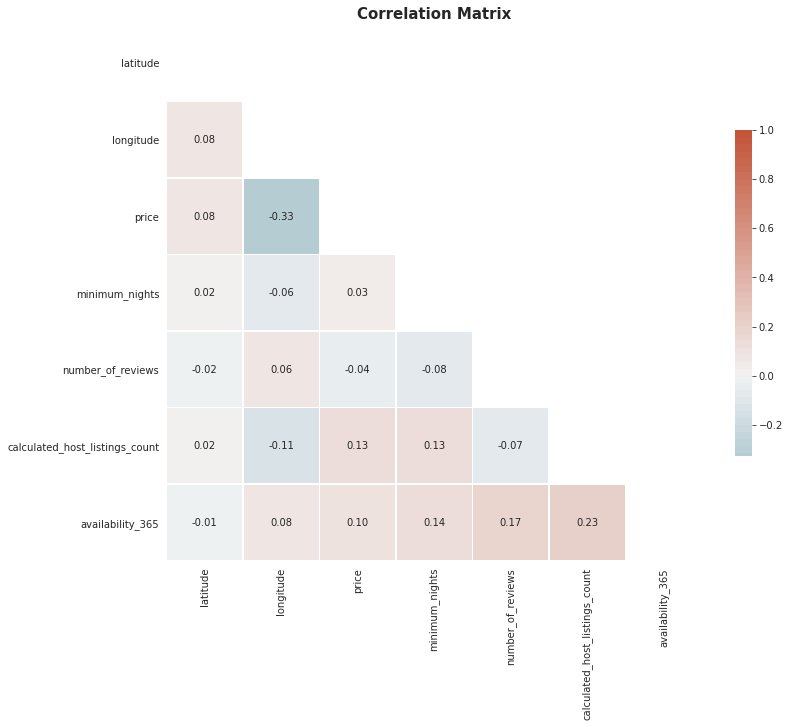

In [79]:
plt.figure(figsize=(12,12))
palette = sns.diverging_palette(220, 20, n=70)
corr=df.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
with sns.axes_style("whitegrid"): #temporary whitegrid style
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=1, center=0,
                mask=mask, square=True, linewidths=0.5, cbar_kws={"shrink": .5})
    plt.title("Correlation Matrix",size=15, weight='bold')

plt.show()

In [80]:
multicollinearity, V=np.linalg.eig(corr)
multicollinearity

array([1.49644777, 0.55757433, 1.26290538, 0.71919572, 1.07548907,
       1.02424948, 0.86413825])